# Generate Embeddings with Sentence Transformers

This notebook generates vector embeddings for the markdown chunks using Sentence Transformers. These embeddings are essential for semantic search in a RAG (Retrieval-Augmented Generation) system.

We'll use the `sentence-transformers` library, which provides state-of-the-art pre-trained models specifically optimized for semantic similarity tasks.

In [1]:
# Import required libraries
import os
import json
import numpy as np
import pandas as pd
import time
from datetime import datetime
from pathlib import Path
from tqdm.notebook import tqdm # For progress bars in Jupyter
import torch
import pickle
import logging # Added for better logging

In [2]:
# Import Sentence Transformers
from sentence_transformers import SentenceTransformer

In [3]:
# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Input directory for chunked markdown files (output from markdown_chunking.ipynb)
CHUNKS_DIR = "../data/chunks"  
# The aggregated JSON file containing all chunks
ALL_CHUNKS_FILE = os.path.join(CHUNKS_DIR, "all_chunks_by_header.json") 
# Directory to store embeddings and related metadata
EMBEDDINGS_DIR = "../data/embeddings"
# Output directory for log files
LOGS_DIR = "../logs" 
# Sentence Transformer model name
#MODEL_NAME = "all-MiniLM-L6-v2" # Good balance of speed and performance
MODEL_NAME = "all-mpnet-base-v2" # Higher quality but slower
# Batch size for encoding
ENCODING_BATCH_SIZE = 32

In [5]:
# Create output directories if they don't exist
Path(EMBEDDINGS_DIR).mkdir(parents=True, exist_ok=True)
Path(LOGS_DIR).mkdir(parents=True, exist_ok=True)

In [6]:
# Setup logging
log_file = Path(LOGS_DIR) / f"generate_embeddings_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(module)s - %(funcName)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file, encoding='utf-8'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

In [7]:
def load_chunks_from_json(chunks_filepath_str):
    """
    Load chunks from a JSON file.
    Expects chunks to have 'page_content' (or 'content') and 'metadata'.
    """
    chunks_file = Path(chunks_filepath_str)
    if not chunks_file.exists():
        logger.error(f"Chunks file not found: {chunks_file}. Please ensure the chunking script has run successfully.")
        return []
    
    try:
        with open(chunks_file, "r", encoding="utf-8") as f:
            loaded_chunks = json.load(f)
        logger.info(f"Successfully loaded {len(loaded_chunks)} chunks from {chunks_file}")
        
        # Display a sample of the first chunk for verification
        if loaded_chunks:
            first_chunk_sample = loaded_chunks[0]
            content_key = 'page_content' if 'page_content' in first_chunk_sample else 'content'
            logger.info(f"\nSample of first chunk (content key: '{content_key}'):")
            logger.info("-" * 80)
            logger.info(f"{first_chunk_sample.get(content_key, '')[:300]}...")
            logger.info("-" * 80)
            logger.info(f"Metadata sample: {json.dumps(first_chunk_sample.get('metadata', {}), indent=2)[:300]}...")
        return loaded_chunks
    except json.JSONDecodeError as e:
        logger.error(f"Error decoding JSON from {chunks_file}: {e}")
        return []
    except Exception as e:
        logger.error(f"Unexpected error loading chunks from {chunks_file}: {e}", exc_info=True)
        return []

In [8]:
def initialize_embedding_model(model_name=MODEL_NAME):
    """
    Initialize a Sentence Transformer model and move it to the appropriate device.
    """
    logger.info(f"Initializing Sentence Transformer model: {model_name}")
    try:
        model = SentenceTransformer(model_name)
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = model.to(device)
        logger.info(f"Model '{model_name}' initialized successfully on device: {device}")
        logger.info(f"Embedding dimension: {model.get_sentence_embedding_dimension()}")
        return model
    except Exception as e:
        logger.error(f"Failed to initialize Sentence Transformer model '{model_name}': {e}", exc_info=True)
        return None

In [9]:
def generate_embeddings_for_chunks(chunks_data, model, batch_size=ENCODING_BATCH_SIZE):
    """
    Generate embeddings for a list of chunk dictionaries.
    """
    if not chunks_data or model is None:
        logger.warning("No chunks or model provided for embedding generation.")
        return np.array([]), []

    # Use 'page_content' if available (from LangChain Document), otherwise fallback to 'content'
    texts_to_embed = [chunk.get('page_content', chunk.get('content', '')) for chunk in chunks_data]
    
    # Filter out any potentially empty texts to avoid issues with some embedding models
    valid_texts_with_indices = [(text, i) for i, text in enumerate(texts_to_embed) if text and text.strip()]
    if not valid_texts_with_indices:
        logger.warning("No valid text content found in chunks to embed.")
        return np.array([]), chunks_data # Return original chunks if no text to embed

    valid_texts = [text for text, i in valid_texts_with_indices]
    original_indices = [i for text, i in valid_texts_with_indices]

    logger.info(f"Generating embeddings for {len(valid_texts)} non-empty text chunks (out of {len(chunks_data)} total) with batch size {batch_size}...")
    
    try:
        embeddings_array = model.encode(valid_texts, batch_size=batch_size, show_progress_bar=True, convert_to_numpy=True)
        logger.info(f"Generated embeddings shape: {embeddings_array.shape}")

        # Add embeddings back to the corresponding original chunks
        # Initialize with None or an empty list for chunks that had no valid text
        for chunk in chunks_data:
            chunk['embedding'] = None 

        for idx_in_embeddings_array, original_chunk_idx in enumerate(original_indices):
            chunks_data[original_chunk_idx]['embedding'] = embeddings_array[idx_in_embeddings_array].tolist() # Convert to list for JSON
        
        return embeddings_array, chunks_data # Return all chunks, some might have None embedding
    except Exception as e:
        logger.error(f"Error during embedding generation: {e}", exc_info=True)
        # Ensure all chunks have an 'embedding' key, even if it's None due to error
        for chunk in chunks_data:
            if 'embedding' not in chunk:
                 chunk['embedding'] = None
        return np.array([]), chunks_data

In [10]:
def save_embedding_data(chunks_with_embeddings_list, embeddings_array_all, output_dir_str):
    """
    Save chunks with embeddings, the embeddings array, and a separate metadata file.
    """
    embeddings_path = Path(output_dir_str)
    embeddings_path.mkdir(parents=True, exist_ok=True) # Ensure directory exists

    # 1. Save chunks with their embeddings (embeddings as lists) in JSON
    json_full_output_path = embeddings_path / "chunks_with_embeddings.json"
    try:
        with open(json_full_output_path, "w", encoding="utf-8") as f:
            json.dump(chunks_with_embeddings_list, f, indent=2, ensure_ascii=False)
        logger.info(f"Saved chunks with embeddings (JSON) to: {json_full_output_path}")
    except Exception as e:
        logger.error(f"Error saving chunks_with_embeddings.json: {e}", exc_info=True)

    # 2. Save chunks with embeddings as Pickle (embeddings can remain as lists or be converted back to np.array if needed before pickling)
    pickle_output_path = embeddings_path / "chunks_with_embeddings.pkl"
    try:
        with open(pickle_output_path, "wb") as f:
            pickle.dump(chunks_with_embeddings_list, f)
        logger.info(f"Saved chunks with embeddings (Pickle) to: {pickle_output_path}")
    except Exception as e:
        logger.error(f"Error saving chunks_with_embeddings.pkl: {e}", exc_info=True)

    # 3. Save only the embeddings as a NumPy array
    # Ensure embeddings_array_all contains only valid embeddings (not None) before saving
    valid_embeddings_for_npy = [chunk['embedding'] for chunk in chunks_with_embeddings_list if chunk['embedding'] is not None]
    if valid_embeddings_for_npy:
        embeddings_npy_array = np.array(valid_embeddings_for_npy)
        npy_output_path = embeddings_path / "embeddings.npy"
        try:
            np.save(npy_output_path, embeddings_npy_array)
            logger.info(f"Saved embeddings array (NumPy .npy) to: {npy_output_path} (Shape: {embeddings_npy_array.shape})")
        except Exception as e:
            logger.error(f"Error saving embeddings.npy: {e}", exc_info=True)
    else:
        logger.warning("No valid embeddings to save to embeddings.npy.")


    # 4. Save a lightweight metadata file (without embeddings or full content)
    # This preserves the original chunk_id from the chunking script.
    lightweight_metadata_list = []
    for i, chunk_data in enumerate(chunks_with_embeddings_list):
        meta_item = chunk_data.get('metadata', {}).copy()
        # Ensure a unique identifier is present, prefer 'chunk_id' if it exists from chunking
        if 'chunk_id' not in meta_item:
            meta_item['chunk_id'] = f"{meta_item.get('filename', 'unknown')}_{meta_item.get('chunk_number', i)}"
        
        # Add a reference to the original index in the aggregated file
        meta_item['original_aggregated_index'] = i 
        
        # Optionally add a short snippet of content for quick reference
        content_key = 'page_content' if 'page_content' in chunk_data else 'content'
        meta_item['content_snippet'] = (chunk_data.get(content_key, '')[:75] + "...") if chunk_data.get(content_key) else ""
        
        lightweight_metadata_list.append(meta_item)
    
    metadata_json_path = embeddings_path / "chunks_metadata_only.json"
    try:
        with open(metadata_json_path, "w", encoding="utf-8") as f:
            json.dump(lightweight_metadata_list, f, indent=2, ensure_ascii=False)
        logger.info(f"Saved lightweight metadata (JSON) to: {metadata_json_path}")
    except Exception as e:
        logger.error(f"Error saving chunks_metadata_only.json: {e}", exc_info=True)

In [11]:
def analyze_embedding_stats(embeddings_np_array, chunks_data_list):
    """
    Analyze and visualize embeddings.
    """
    if embeddings_np_array.size == 0:
        logger.info("No embeddings to analyze.")
        return

    logger.info(f"\n--- Embeddings Analysis ---")
    logger.info(f"Embeddings array shape: {embeddings_np_array.shape}")
    if embeddings_np_array.ndim > 1:
        logger.info(f"Embedding dimension: {embeddings_np_array.shape[1]}")
        mean_embedding_sample = np.mean(embeddings_np_array, axis=0)[:5]
        std_embedding_sample = np.std(embeddings_np_array, axis=0)[:5]
        logger.info(f"Mean embedding (first 5 dims): {mean_embedding_sample}")
        logger.info(f"Std deviation (first 5 dims): {std_embedding_sample}")

        embedding_norms = np.linalg.norm(embeddings_np_array, axis=1)
        plt.figure(figsize=(10, 6))
        sns.histplot(embedding_norms, bins=30, kde=True)
        plt.title("Distribution of Embedding L2 Norms")
        plt.xlabel("L2 Norm")
        plt.ylabel("Frequency")
        plt.grid(True, alpha=0.3)
        plt.show()

        # Cosine similarity matrix for a sample
        sample_size = min(100, embeddings_np_array.shape[0])
        sample_indices = np.random.choice(embeddings_np_array.shape[0], sample_size, replace=False)
        sample_embeddings_for_similarity = embeddings_np_array[sample_indices]
        
        similarity_matrix = np.dot(sample_embeddings_for_similarity, sample_embeddings_for_similarity.T)
        norms = np.linalg.norm(sample_embeddings_for_similarity, axis=1, keepdims=True)
        similarity_matrix = similarity_matrix / (norms * norms.T)
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(similarity_matrix, cmap="viridis", vmin=-1, vmax=1) # Cosine similarity ranges from -1 to 1
        plt.title(f"Cosine Similarity Matrix (Sample of {sample_size} Embeddings)")
        plt.tight_layout()
        plt.show()

    # Category analysis if metadata is available
    categories = [chunk.get('metadata', {}).get('category', 'unknown') for chunk in chunks_data_list if chunk.get('embedding') is not None]
    valid_embedding_norms = [np.linalg.norm(np.array(chunk['embedding'])) for chunk in chunks_data_list if chunk.get('embedding') is not None]

    if categories and len(set(categories)) > 1:
        category_df = pd.DataFrame({'category': categories, 'embedding_norm': valid_embedding_norms})
        plt.figure(figsize=(12, 7))
        sns.boxplot(x='category', y='embedding_norm', data=category_df)
        plt.title("Embedding L2 Norms by Category")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.show()

In [12]:
def test_semantic_search(query_text, model_instance, all_chunks_with_embeds, top_k_results=5):
    """
    Perform a simple semantic search for testing purposes.
    """
    if not all_chunks_with_embeds or model_instance is None:
        logger.warning("Cannot perform semantic search: chunks or model not available.")
        return []

    logger.info(f"\n--- Semantic Search Test ---")
    logger.info(f"Query: \"{query_text}\"")
    
    query_embedding_np = model_instance.encode(query_text, convert_to_numpy=True)
    
    # Filter out chunks that might not have valid embeddings
    valid_chunks_for_search = [chunk for chunk in all_chunks_with_embeds if chunk.get('embedding') is not None]
    if not valid_chunks_for_search:
        logger.warning("No chunks with valid embeddings available for search.")
        return []

    chunk_embeddings_np = np.array([chunk['embedding'] for chunk in valid_chunks_for_search])
    
    # Calculate cosine similarities
    similarities = np.dot(chunk_embeddings_np, query_embedding_np.T) / \
                   (np.linalg.norm(chunk_embeddings_np, axis=1) * np.linalg.norm(query_embedding_np))
    
    # Get top_k results
    # argsort returns indices that would sort the array. We want descending, so we negate.
    sorted_indices_desc = np.argsort(-similarities)[:top_k_results] 
    
    results = []
    logger.info("-" * 80)
    for i, idx in enumerate(sorted_indices_desc):
        chunk = valid_chunks_for_search[idx]
        score = similarities[idx]
        content_key = 'page_content' if 'page_content' in chunk else 'content'
        logger.info(f"Result {i+1} (Score: {score:.4f})")
        logger.info(f"Source: {chunk.get('metadata', {}).get('filename', 'Unknown')}, Chunk ID: {chunk.get('metadata', {}).get('chunk_id', 'N/A')}")
        logger.info(f"Content: {chunk.get(content_key, '')[:200]}...")
        logger.info("-" * 80)
        results.append({'chunk': chunk, 'score': score})
    return results

2025-05-12 20:29:42,202 - INFO - 2485082412 - <module> - --- Starting Embedding Generation Process ---
2025-05-12 20:29:42,334 - INFO - 4182094878 - load_chunks_from_json - Successfully loaded 11532 chunks from ..\data\chunks\all_chunks_aggregated.json
2025-05-12 20:29:42,335 - INFO - 4182094878 - load_chunks_from_json - 
Sample of first chunk (content key: 'page_content'):
2025-05-12 20:29:42,335 - INFO - 4182094878 - load_chunks_from_json - --------------------------------------------------------------------------------
2025-05-12 20:29:42,336 - INFO - 4182094878 - load_chunks_from_json - 11th Hour Project Software and Data Hub...
2025-05-12 20:29:42,338 - INFO - 4182094878 - load_chunks_from_json - --------------------------------------------------------------------------------
2025-05-12 20:29:42,339 - INFO - 4182094878 - load_chunks_from_json - Metadata sample: {
  "title": "11th Hour Project Software and Data Hub \u2013 DSI",
  "original_url": "https://datascience.uchicago.edu/11

Batches:   0%|          | 0/361 [00:00<?, ?it/s]

2025-05-12 20:31:31,075 - INFO - 3151586935 - generate_embeddings_for_chunks - Generated embeddings shape: (11532, 384)
2025-05-12 20:31:37,306 - INFO - 550123323 - save_embedding_data - Saved chunks with embeddings (JSON) to: ..\data\embeddings\chunks_with_embeddings.json
2025-05-12 20:31:37,480 - INFO - 550123323 - save_embedding_data - Saved chunks with embeddings (Pickle) to: ..\data\embeddings\chunks_with_embeddings.pkl
2025-05-12 20:31:37,693 - INFO - 550123323 - save_embedding_data - Saved embeddings array (NumPy .npy) to: ..\data\embeddings\embeddings.npy (Shape: (11532, 384))
2025-05-12 20:31:37,866 - INFO - 550123323 - save_embedding_data - Saved lightweight metadata (JSON) to: ..\data\embeddings\chunks_metadata_only.json
2025-05-12 20:31:37,870 - INFO - 1986813434 - analyze_embedding_stats - 
--- Embeddings Analysis ---
2025-05-12 20:31:37,871 - INFO - 1986813434 - analyze_embedding_stats - Embeddings array shape: (11532, 384)
2025-05-12 20:31:37,872 - INFO - 1986813434 - an

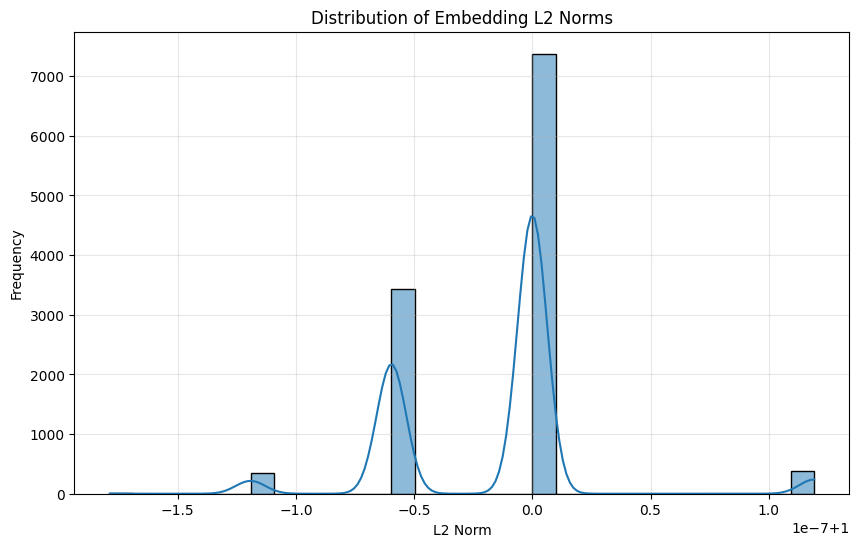

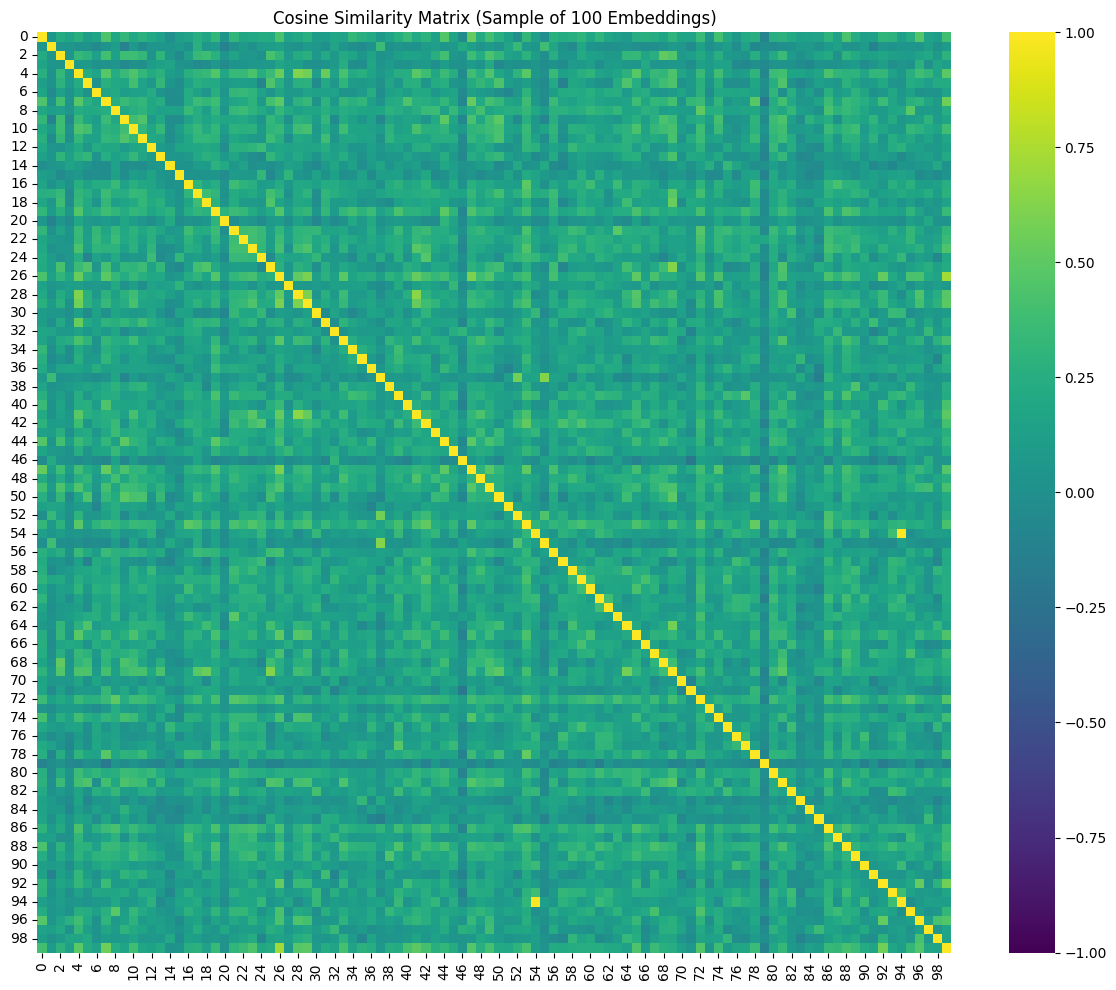

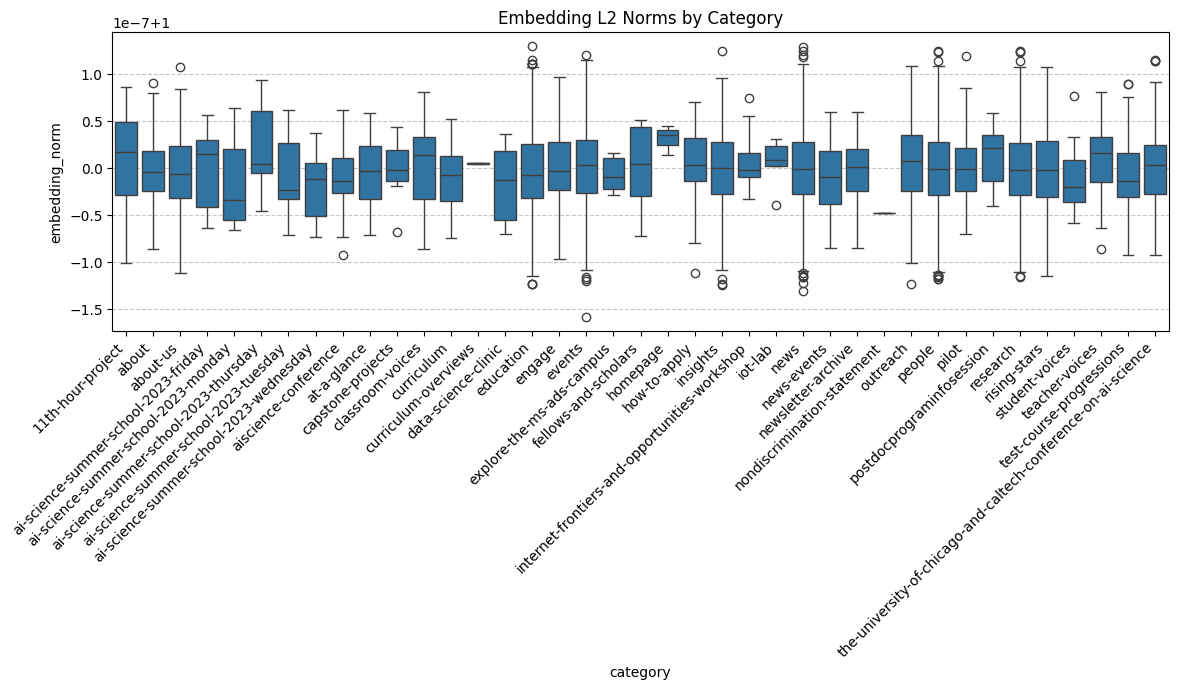

2025-05-12 20:31:39,511 - INFO - 3243247844 - test_semantic_search - 
--- Semantic Search Test ---
2025-05-12 20:31:39,512 - INFO - 3243247844 - test_semantic_search - Query: "What courses are required for the Masters in Data Science?"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-05-12 20:31:39,805 - INFO - 3243247844 - test_semantic_search - --------------------------------------------------------------------------------
2025-05-12 20:31:39,806 - INFO - 3243247844 - test_semantic_search - Result 1 (Score: 0.7194)
2025-05-12 20:31:39,806 - INFO - 3243247844 - test_semantic_search - Source: education-undergrad-major.md, Chunk ID: education-undergrad-major_0
2025-05-12 20:31:39,807 - INFO - 3243247844 - test_semantic_search - Content: Undergraduate Data Science Major...
2025-05-12 20:31:39,808 - INFO - 3243247844 - test_semantic_search - --------------------------------------------------------------------------------
2025-05-12 20:31:39,809 - INFO - 3243247844 - test_semantic_search - Result 2 (Score: 0.6993)
2025-05-12 20:31:39,809 - INFO - 3243247844 - test_semantic_search - Source: education-masters-programs-online-program.md, Chunk ID: education-masters-programs-online-program_14
2025-05-12 20:31:39,810 - INFO - 3243247844 - test_semantic_search - Conten

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-05-12 20:31:40,119 - INFO - 3243247844 - test_semantic_search - --------------------------------------------------------------------------------
2025-05-12 20:31:40,120 - INFO - 3243247844 - test_semantic_search - Result 1 (Score: 0.6445)
2025-05-12 20:31:40,120 - INFO - 3243247844 - test_semantic_search - Source: people-ethan-truelove.md, Chunk ID: people-ethan-truelove_0
2025-05-12 20:31:40,121 - INFO - 3243247844 - test_semantic_search - Content: People
Ethan Truelove
Undergraduate, The University of Chicago
Project: Data and Learning Hub for Science (DLHub)
Mentors/Lab: Logan Ward & Ryan Chard/Globus Labs
Research Area Keywords: Machine Learn...
2025-05-12 20:31:40,122 - INFO - 3243247844 - test_semantic_search - --------------------------------------------------------------------------------
2025-05-12 20:31:40,125 - INFO - 3243247844 - test_semantic_search - Result 2 (Score: 0.6320)
2025-05-12 20:31:40,126 - INFO - 3243247844 - test_semantic_search - Source: news-ml-bias-eth

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-05-12 20:31:40,423 - INFO - 3243247844 - test_semantic_search - --------------------------------------------------------------------------------
2025-05-12 20:31:40,425 - INFO - 3243247844 - test_semantic_search - Result 1 (Score: 0.5571)
2025-05-12 20:31:40,425 - INFO - 3243247844 - test_semantic_search - Source: news-how-one-uchicago-student-found-his-passion-for-teaching.md, Chunk ID: news-how-one-uchicago-student-found-his-passion-for-teaching_5
2025-05-12 20:31:40,427 - INFO - 3243247844 - test_semantic_search - Content: degree. “In this field, a bachelor’s degree is not cutting it,” he explains. “That’s why I ultimately decided to enroll in the program at UChicago.”...
2025-05-12 20:31:40,428 - INFO - 3243247844 - test_semantic_search - --------------------------------------------------------------------------------
2025-05-12 20:31:40,429 - INFO - 3243247844 - test_semantic_search - Result 2 (Score: 0.5205)
2025-05-12 20:31:40,430 - INFO - 3243247844 - test_semantic_search 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-05-12 20:31:40,744 - INFO - 3243247844 - test_semantic_search - --------------------------------------------------------------------------------
2025-05-12 20:31:40,745 - INFO - 3243247844 - test_semantic_search - Result 1 (Score: 0.7700)
2025-05-12 20:31:40,746 - INFO - 3243247844 - test_semantic_search - Source: capstone-projects.md, Chunk ID: capstone-projects_0
2025-05-12 20:31:40,747 - INFO - 3243247844 - test_semantic_search - Content: Capstone Projects...
2025-05-12 20:31:40,748 - INFO - 3243247844 - test_semantic_search - --------------------------------------------------------------------------------
2025-05-12 20:31:40,749 - INFO - 3243247844 - test_semantic_search - Result 2 (Score: 0.7700)
2025-05-12 20:31:40,749 - INFO - 3243247844 - test_semantic_search - Source: education-masters-programs-ms-in-applied-data-science-capstone-projects.md, Chunk ID: education-masters-programs-ms-in-applied-data-science-capstone-projects_0
2025-05-12 20:31:40,750 - INFO - 3243247844 - t

In [13]:
logger.info("--- Starting Embedding Generation Process ---")
embedding_start_time = time.time()

# 1. Load chunks
all_chunks = load_chunks_from_json(ALL_CHUNKS_FILE)

if all_chunks:
    # 2. Initialize model
    embedding_model = initialize_embedding_model(MODEL_NAME)

    if embedding_model:
        # 3. Generate embeddings and add them to the chunks list
        # The generate_embeddings_for_chunks function now modifies chunks_data in-place
        # and also returns the numpy array of embeddings.
        generated_embeddings_np, chunks_with_embedded_data = generate_embeddings_for_chunks(all_chunks, embedding_model)

        # 4. Save embeddings and metadata
        save_embedding_data(chunks_with_embedded_data, generated_embeddings_np, EMBEDDINGS_DIR)

        # 5. Analyze embeddings (optional, for verification)
        if generated_embeddings_np.size > 0 : # Check if any embeddings were actually generated
                analyze_embedding_stats(generated_embeddings_np, chunks_with_embedded_data)
        else:
            logger.info("Skipping embedding analysis as no embeddings were generated.")


        # 6. Test semantic search (optional, for verification)
        test_queries_list = [
            "What courses are required for the Masters in Data Science?",
            "Who teaches machine learning in the program?",
            "How long does it take to complete the degree?",
            "What are the capstone project requirements?"
        ]
        for t_query in test_queries_list:
            test_semantic_search(t_query, embedding_model, chunks_with_embedded_data)
    else:
        logger.error("Embedding model initialization failed. Cannot proceed.")
else:
    logger.error(f"No chunks loaded from {ALL_CHUNKS_FILE}. Cannot proceed with embedding generation.")

embedding_end_time = time.time()
elapsed_time = embedding_end_time - embedding_start_time
logger.info(f"--- Embedding Generation Process Completed in {elapsed_time:.2f} seconds ---")